# Clean data from SCHMA

In this notebook, we will clean data from the <a href="http://steinhardt.nyu.edu/research_alliance/research/schma"> School-Level Master File</a>. This dataset is produced by the Research Alliance for New York City Schools at NYU. They describe it as follows:

<i>The School-Level Master File (SCHMA) is a dataset developed by the Research Alliance for New York City Schools at New York University. To create the file, we compiled publicly available data from the New York City Department of Education (DOE) and the U.S. Department of Education. The result is a consistent, accessible document that can be used to investigate characteristics of individual New York City schools or groups of schools and how they have changed over time.</i>

We will use the SCHMA to obtain the following information about NYC schools from 2006-2012:
1. Persistent DBN's (unique school identifier)
2. National Center for Education Statistics (NCES) school IDs (used to merge NYC data with DonorsChoose data).
3. Number of FTE teachers.

In [2]:
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

raw_SCHMA = pd.read_csv('SCHMA/schma19962013.csv', low_memory=False)

First read in only records for schools present in 2013, starting in 2006.
Then select the relevant features (YEAR, BNLONG, NCESSCH, BOROUGH, AND CCDNUMFTE).

In [3]:
proc_SCHMA = raw_SCHMA.loc[(2006 <= raw_SCHMA.YEAR)]
proc_SCHMA = proc_SCHMA.loc[(2013 == proc_SCHMA.BNLONG_YRLAST)]
proc_SCHMA = proc_SCHMA[['YEAR', 'BNLONG','NCESSCH','BOROUGH','CCDNUMFTE']]

Next, merge the records for each school for each year (with the year range
reflecting data available in the School Demographics and Accountability Snapshot).
For example, school M110 will have records for all years 2006-2012.

In [4]:
merged_by_school = proc_SCHMA.loc[(2006 == proc_SCHMA.YEAR)]
merged_by_school = merged_by_school.drop('YEAR',axis=1)

years = range(2007,2013)
for year in years:
    proc_SCHMA_year = proc_SCHMA.loc[(year == proc_SCHMA.YEAR)]
    proc_SCHMA_year = proc_SCHMA_year.drop(['BOROUGH','YEAR'],axis=1)
    new_col_index = ['BNLONG']
    for feature in proc_SCHMA_year.columns:
        if feature != 'BNLONG':
            feature = str(year) + '_' + feature
            new_col_index.append(feature)
    proc_SCHMA_year.columns = new_col_index
    merged_by_school = pd.merge(merged_by_school, proc_SCHMA_year, how='inner', on='BNLONG')

Next, determine the number of schools with NCES ID's available in the SCHMA, and replace year-by-year
values with the most commonly reported NCES ID's. Specifically, potential conflicts are resolved
using the mode (i.e. if multiple NCES ID's are reported, only the most frequent will be retained).

In [5]:
NCESSCH_inputed_modes, bins = mode(merged_by_school[['NCESSCH','2007_NCESSCH','2008_NCESSCH','2009_NCESSCH','2010_NCESSCH','2011_NCESSCH','2012_NCESSCH']],axis=1)
print 'NCES ID not available for ' + str(len(NCESSCH_inputed_modes[NCESSCH_inputed_modes == 0.0])) + ' schools.'
print 'NCES ID available for ' + str(len(np.unique(NCESSCH_inputed_modes))-1) + ' schools.'
clean_SCHMA_data = merged_by_school.drop(['NCESSCH', 'NCESSCH','2007_NCESSCH','2008_NCESSCH','2009_NCESSCH','2010_NCESSCH','2011_NCESSCH','2012_NCESSCH'],axis=1)
clean_SCHMA_data['NCES_ID'] = NCESSCH_inputed_modes
clean_SCHMA_data = clean_SCHMA_data[clean_SCHMA_data.NCES_ID != 0.0]

NCES ID not available for 399 schools.
NCES ID available for 924 schools.


Now initial exploration: print null values by feature, and then count by 'Borough'.

In [6]:
print clean_SCHMA_data.isnull().sum()
print 'Number of schools with missing values: ' + str(len(clean_SCHMA_data[clean_SCHMA_data.isnull().any(axis=1)]))

grouped = clean_SCHMA_data.groupby('BOROUGH')['BNLONG']
print grouped.count()

BNLONG             0
BOROUGH            0
CCDNUMFTE         26
2007_CCDNUMFTE    19
2008_CCDNUMFTE     8
2009_CCDNUMFTE     5
2010_CCDNUMFTE     0
2011_CCDNUMFTE     0
2012_CCDNUMFTE     0
NCES_ID            0
dtype: int64
Number of schools with missing values: 33
BOROUGH
K    308
M    202
Q    185
R      8
X    221
Name: BNLONG, dtype: int64


In [7]:
clean_SCHMA_data.describe()

,CCDNUMFTE,2007_CCDNUMFTE,2008_CCDNUMFTE,2009_CCDNUMFTE,2010_CCDNUMFTE,2011_CCDNUMFTE,2012_CCDNUMFTE,NCES_ID
count,898.000000,905.000000,916.000000,919.000000,924.000000,924.000000,924.000000,9.240000e+02
mean,47.435412,48.811492,48.100328,48.639717,46.735422,45.391201,43.904621,3.600100e+11
std,35.910808,33.860437,32.809045,31.824948,30.005787,29.301420,29.425692,2.222157e+06
min,3.000000,8.000000,6.000000,6.000000,8.000000,8.010000,6.400000,3.600076e+11
25%,23.000000,26.300000,27.000000,28.000000,27.010000,26.252500,26.000000,3.600085e+11
50%,40.000000,41.200000,40.000000,41.000000,39.025000,38.030000,37.000000,3.600092e+11
75%,59.000000,60.000000,58.050000,60.000000,57.000000,55.002500,52.010000,3.600103e+11
max,282.000000,253.600000,258.600000,246.100000,244.000000,230.050000,244.310000,3.600153e+11


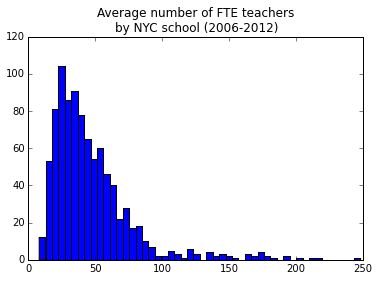

In [9]:
%matplotlib inline
fte = plt.hist(clean_SCHMA_data.drop(['NCES_ID'],axis=1).mean(axis=1).values,bins=50)
plt.title('Average number of FTE teachers\nby NYC school (2006-2012)')

In [10]:
clean_SCHMA_data.head(6)

,BNLONG,BOROUGH,CCDNUMFTE,2007_CCDNUMFTE,2008_CCDNUMFTE,2009_CCDNUMFTE,2010_CCDNUMFTE,2011_CCDNUMFTE,2012_CCDNUMFTE,NCES_ID
6,M110,M,44,37.0,34.0,35.9,35.01,34.82,33.01,3.600076e+11
7,M134,M,32,35.0,31.5,33.0,32.00,31.40,31.50,3.600076e+11
8,M137,M,32,28.5,23.8,24.7,21.00,22.14,22.02,3.600076e+11
9,M140,M,39,38.0,37.0,38.1,36.01,32.66,29.00,3.600076e+11
10,M142,M,46,41.0,41.0,38.0,38.50,39.51,36.00,3.600076e+11
11,M184,M,25,32.0,33.2,39.0,42.26,40.77,42.00,3.600076e+11


Finally, we make BNLONG the index.

In [11]:
clean_SCHMA_data = clean_SCHMA_data.set_index(['BNLONG'])
clean_SCHMA_data.head(6)

,BOROUGH,CCDNUMFTE,2007_CCDNUMFTE,2008_CCDNUMFTE,2009_CCDNUMFTE,2010_CCDNUMFTE,2011_CCDNUMFTE,2012_CCDNUMFTE,NCES_ID
BNLONG,,,,,,,,,
M110,M,44,37.0,34.0,35.9,35.01,34.82,33.01,3.600076e+11
M134,M,32,35.0,31.5,33.0,32.00,31.40,31.50,3.600076e+11
M137,M,32,28.5,23.8,24.7,21.00,22.14,22.02,3.600076e+11
M140,M,39,38.0,37.0,38.1,36.01,32.66,29.00,3.600076e+11
M142,M,46,41.0,41.0,38.0,38.50,39.51,36.00,3.600076e+11
M184,M,25,32.0,33.2,39.0,42.26,40.77,42.00,3.600076e+11
